**Import dependencies**

In [3]:
import os
import random
import shutil
import glob
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Show sample images from the dataset**

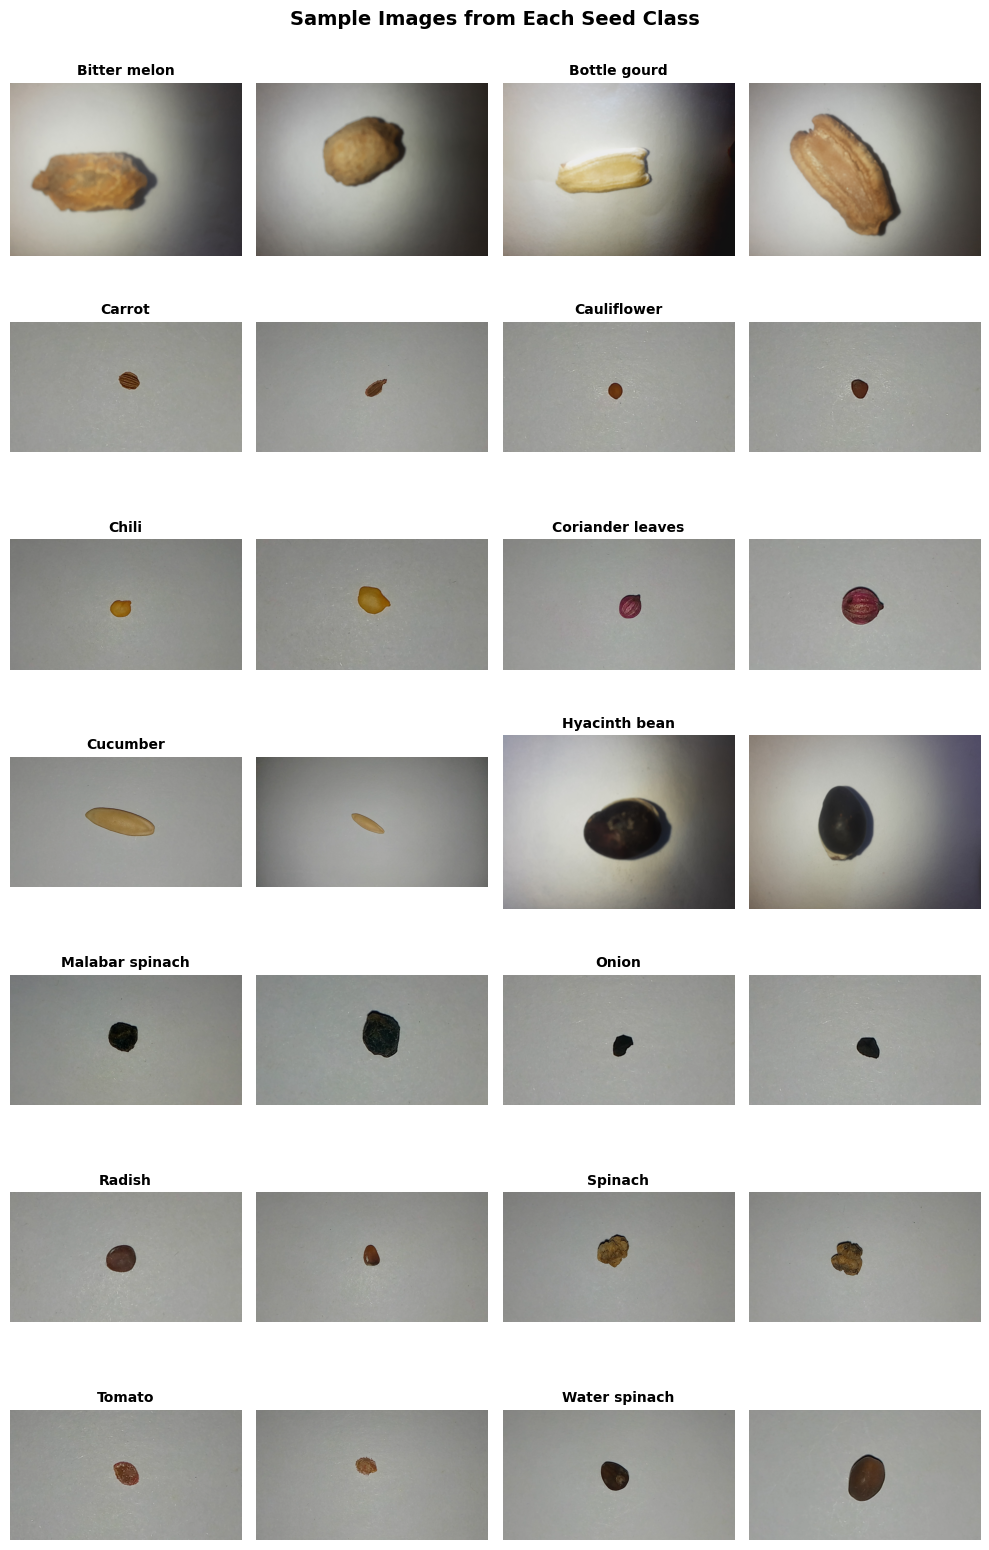

In [42]:
# Configuration
dataset_path = '/kaggle/input/vegetable-seed-dataset/vegetable_seed_dataset'  # Your original dataset path
classes = ['Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili',
           'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach',
           'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach']

samples_per_class = 2  # Number of samples per class

fig, axes = plt.subplots(7, 4, figsize=(10, 16))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(images, min(samples_per_class, len(images)))
    
    for j, img_name in enumerate(sample_images):
        ax_idx = idx * 2 + j
        img = Image.open(os.path.join(class_path, img_name))
        axes[ax_idx].imshow(img)
        axes[ax_idx].axis('off')
        if j == 0:
            axes[ax_idx].set_title(class_name, fontsize=10, fontweight='bold')

plt.suptitle('Sample Images from Each Seed Class', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()

**Visualize number of images per class**

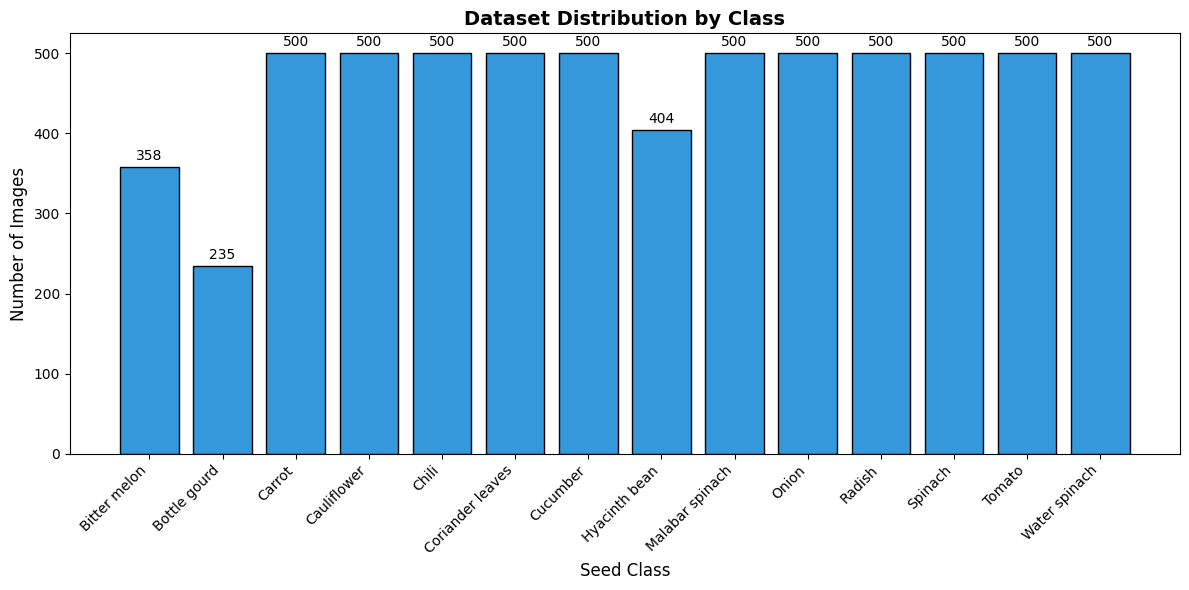


Total images: 6497


In [45]:
# Configuration
dataset_path = '/kaggle/input/vegetable-seed-dataset/vegetable_seed_dataset'
classes = ['Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili',
           'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach',
           'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach']

# Count images per class
counts = []
for cls in classes:
    path = os.path.join(dataset_path, cls)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    counts.append(count)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, counts, color='#3498db', edgecolor='black')
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Seed Class', fontsize=12)
plt.title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal images: {sum(counts)}")

**Create train/val/test split**

In [8]:
random.seed(42)

SRC = '/kaggle/input/vegetable-seed-dataset/vegetable_seed_dataset'   # Path with all 14 class folders
OUT = '/kaggle/working/vegetable_seed_dataset_split'  # Will be created

ratios = (0.7, 0.15, 0.15)  # train, val, test

classes = [
    'Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili',
    'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach',
    'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach'
]

for cls in classes:
    src_dir = os.path.join(SRC, cls)

    # Collect all common image files in any case
    imgs = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
        imgs.extend(glob.glob(os.path.join(src_dir, ext)))

    if len(imgs) == 0:
        print(f"Warning: No images found in {src_dir}")
        continue  # Skip this class if empty

    random.shuffle(imgs)
    n = len(imgs)
    ntrain = int(n * ratios[0])
    nval = int(n * ratios[1])

    train_files = imgs[:ntrain]
    val_files = imgs[ntrain:ntrain+nval]
    test_files = imgs[ntrain+nval:]

    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(OUT, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in files:
            shutil.copy(f, out_dir)

print("Done. Created dataset under:", OUT)
DATA_DIR = OUT


Done. Created dataset under: /kaggle/working/vegetable_seed_dataset_split


**Create tf.data pipelines + augmentation**

In [10]:
IMG_SIZE = (224, 224)   # good default for these models
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print("Classes found:", class_names)

# Prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Simple augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

Found 4546 files belonging to 14 classes.
Found 973 files belonging to 14 classes.
Found 978 files belonging to 14 classes.
Classes found: ['Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili', 'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach', 'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach']


**Utility: build model function (transfer learning)**

In [11]:
def build_transfer_model(base_model_name, input_shape=IMG_SIZE+(3,), n_classes=14, base_trainable=False):
    """
    base_model_name: one of 'EfficientNetB0', 'MobileNetV3Large', 'ResNet50V2'
    base_trainable: whether to unfreeze base for fine-tuning
    """
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    if base_model_name == 'EfficientNetB0':
        preproc = tf.keras.applications.efficientnet.preprocess_input
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'MobileNetV3Large':
        preproc = tf.keras.applications.mobilenet_v3.preprocess_input
        base = tf.keras.applications.MobileNetV3Large(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'ResNet50V2':
        preproc = tf.keras.applications.resnet_v2.preprocess_input
        base = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError("Unknown model")

    x = layers.Lambda(preproc)(x)
    x = base(x, training=False)   # keep batchnorm in inference mode when base frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    # FIXED: Changed to softmax activation for multi-class classification
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # Freeze or unfreeze base as requested
    base.trainable = base_trainable

    return model, base

**Training helper (freeze-then-finetune)**

In [12]:
def compile_and_train(model, train_ds, val_ds, lr=1e-3, epochs=10, model_name='model'):
    # FIXED: Changed to sparse_categorical_crossentropy for multi-class classification
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

**Train three models (steps to run sequentially)**

In [13]:
# 1) EfficientNetB0
model_e, base_e = build_transfer_model('EfficientNetB0', base_trainable=False)
print(model_e.summary())
history_e = compile_and_train(model_e, train_ds, val_ds, lr=1e-3, epochs=12, model_name='effnetb0_stage1')

# Fine-tune: unfreeze last some layers
base_e.trainable = True
# Optionally freeze first layers and unfreeze last block
for layer in base_e.layers[:-30]:
    layer.trainable = False
for layer in base_e.layers[-30:]:
    layer.trainable = True

history_e_ft = compile_and_train(model_e, train_ds, val_ds, lr=1e-5, epochs=8, model_name='effnetb0_finetune')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,345 (16.08 MB)

 Trainable params: 165,774 (647.55 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/12


E0000 00:00:1765956426.459908      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1765956431.055645     205 cuda_dnn.cc:529] Loaded cuDNN version 91002


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7030 - loss: 1.0258

143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 523ms/step - accuracy: 0.7053 - loss: 1.0183 - val_accuracy: 0.9938 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 2/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9719 - loss: 0.1090

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.9720 - loss: 0.1088 - val_accuracy: 0.9938 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 3/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9823 - loss: 0.0619

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 511ms/step - accuracy: 0.9823 - loss: 0.0619 - val_accuracy: 0.9959 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 4/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9870 - loss: 0.0520

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 507ms/step - accuracy: 0.9870 - loss: 0.0520 - val_accuracy: 0.9949 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 5/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9840 - loss: 0.0551

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 506ms/step - accuracy: 0.9840 - loss: 0.0550 - val_accuracy: 0.9959 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9906 - loss: 0.0350

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 508ms/step - accuracy: 0.9906 - loss: 0.0350 - val_accuracy: 0.9959 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 7/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9887 - loss: 0.0371

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 505ms/step - accuracy: 0.9887 - loss: 0.0371 - val_accuracy: 0.9949 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 8/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9918 - loss: 0.0286

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.9918 - loss: 0.0286 - val_accuracy: 0.9969 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 9/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9923 - loss: 0.0263

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 505ms/step - accuracy: 0.9923 - loss: 0.0264 - val_accuracy: 0.9959 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 10/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 500ms/step - accuracy: 0.9745 - loss: 0.0815 - val_accuracy: 0.9949 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 11/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 504ms/step - accuracy: 0.9893 - loss: 0.0329 - val_accuracy: 0.9928 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 12/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9914 - loss: 0.0232

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 500ms/step - accuracy: 0.9914 - loss: 0.0233 - val_accuracy: 0.9969 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 1/8


E0000 00:00:1765957314.985655      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9474 - loss: 0.2069

143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 513ms/step - accuracy: 0.9474 - loss: 0.2065 - val_accuracy: 0.9887 - val_loss: 0.0333 - learning_rate: 1.0000e-05
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 506ms/step - accuracy: 0.9705 - loss: 0.1242 - val_accuracy: 0.9887 - val_loss: 0.0445 - learning_rate: 1.0000e-05
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 508ms/step - accuracy: 0.9812 - loss: 0.0865 - val_accuracy: 0.9897 - val_loss: 0.0427 - learning_rate: 1.0000e-05
Epoch 4/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.9788 - loss: 0.0755 - val_accuracy: 0.9908 - val_loss: 0.0354 - learning_rate: 1.0000e-05
Epoch 5/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 526ms/step - accuracy: 0.9860 - loss: 0.0699 - val_accuracy: 0.9908 - val_loss: 0.0340 - learning_rate: 5.0000e-06
Epoch 6/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9796 - loss: 0.0680

143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 520ms/step - accuracy: 0.9797 - loss: 0.0680 - val_accuracy: 0.9918 - val_loss: 0.0324 - learning_rate: 5.0000e-06
Epoch 7/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9847 - loss: 0.0570

143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.9847 - loss: 0.0570 - val_accuracy: 0.9918 - val_loss: 0.0309 - learning_rate: 5.0000e-06
Epoch 8/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9823 - loss: 0.0575

143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.9823 - loss: 0.0575 - val_accuracy: 0.9918 - val_loss: 0.0287 - learning_rate: 5.0000e-06


In [31]:
# 2) MobileNetV3Large
model_m, base_m = build_transfer_model('MobileNetV3Large', base_trainable=False)
history_m = compile_and_train(model_m, train_ds, val_ds, lr=1e-3, epochs=12, model_name='mobilenetv3_stage1')

base_m.trainable = True
for layer in base_m.layers[:-30]:
    layer.trainable = False
history_m_ft = compile_and_train(model_m, train_ds, val_ds, lr=1e-5, epochs=8, model_name='mobilenetv3_finetune')

Epoch 1/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6311 - loss: 1.1953

143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 497ms/step - accuracy: 0.6338 - loss: 1.1868 - val_accuracy: 0.9363 - val_loss: 0.1752 - learning_rate: 0.0010
Epoch 2/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9478 - loss: 0.1526

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9480 - loss: 0.1522 - val_accuracy: 0.9743 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9755 - loss: 0.0784 - val_accuracy: 0.9661 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 4/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9791 - loss: 0.0611

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9791 - loss: 0.0611 - val_accuracy: 0.9784 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 5/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9832 - loss: 0.0516

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9832 - loss: 0.0516 - val_accuracy: 0.9784 - val_loss: 0.0565 - learning_rate: 0.0010
Epoch 6/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9893 - loss: 0.0362

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9893 - loss: 0.0363 - val_accuracy: 0.9877 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 7/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9785 - loss: 0.0642

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9786 - loss: 0.0641 - val_accuracy: 0.9918 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 8/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9860 - loss: 0.0407 - val_accuracy: 0.9866 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 9/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9904 - loss: 0.0286 - val_accuracy: 0.9908 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 10/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9894 - loss: 0.0363 - val_accuracy: 0.9877 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 11/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9957 - loss: 0.0166

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9957 - loss: 0.0166 - val_accuracy: 0.9897 - val_loss: 0.0209 - learning_rate: 5.0000e-04
Epoch 12/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9945 - loss: 0.0226 - val_accuracy: 0.9908 - val_loss: 0.0263 - learning_rate: 5.0000e-04
Epoch 1/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9340 - loss: 0.2127

143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 499ms/step - accuracy: 0.9342 - loss: 0.2122 - val_accuracy: 0.9949 - val_loss: 0.0180 - learning_rate: 1.0000e-05
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 486ms/step - accuracy: 0.9735 - loss: 0.0981 - val_accuracy: 0.9938 - val_loss: 0.0198 - learning_rate: 1.0000e-05
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9802 - loss: 0.0800 - val_accuracy: 0.9938 - val_loss: 0.0223 - learning_rate: 1.0000e-05
Epoch 4/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.9844 - loss: 0.0596 - val_accuracy: 0.9938 - val_loss: 0.0253 - learning_rate: 1.0000e-05
Epoch 5/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9869 - loss: 0.0458 - val_accuracy: 0.9918 - val_loss: 0.0291 - learning_rate: 5.0000e-06
Epoch 6/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9855 - loss: 0.0510 - val_accuracy: 0.9908 - val_loss: 0.0347 - learning_rate: 5.0000e-06


In [32]:
# 3) ResNet50V2
model_r, base_r = build_transfer_model('ResNet50V2', base_trainable=False)
history_r = compile_and_train(model_r, train_ds, val_ds, lr=1e-3, epochs=12, model_name='resnet50v2_stage1')

base_r.trainable = True
for layer in base_r.layers[:-30]:
    layer.trainable = False
history_r_ft = compile_and_train(model_r, train_ds, val_ds, lr=1e-5, epochs=8, model_name='resnet50v2_finetune')

Epoch 1/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6643 - loss: 1.1469

143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 503ms/step - accuracy: 0.6664 - loss: 1.1388 - val_accuracy: 0.9466 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 2/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9370 - loss: 0.1994

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.9371 - loss: 0.1990 - val_accuracy: 0.9702 - val_loss: 0.0820 - learning_rate: 0.0010
Epoch 3/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9538 - loss: 0.1373

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 493ms/step - accuracy: 0.9539 - loss: 0.1370 - val_accuracy: 0.9784 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 4/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9679 - loss: 0.0979

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.9679 - loss: 0.0979 - val_accuracy: 0.9836 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 5/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9714 - loss: 0.0802

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9714 - loss: 0.0802 - val_accuracy: 0.9877 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9716 - loss: 0.0848 - val_accuracy: 0.9815 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9750 - loss: 0.0731 - val_accuracy: 0.9794 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 8/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9750 - loss: 0.0750

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9750 - loss: 0.0750 - val_accuracy: 0.9897 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 9/12
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9849 - loss: 0.0537

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9849 - loss: 0.0538 - val_accuracy: 0.9897 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 10/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9812 - loss: 0.0606 - val_accuracy: 0.9856 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 11/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9774 - loss: 0.0599 - val_accuracy: 0.9866 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 12/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9856 - loss: 0.0437 - val_accuracy: 0.9743 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 1/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9186 - loss: 0.2773

143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 509ms/step - accuracy: 0.9191 - loss: 0.2758 - val_accuracy: 0.9815 - val_loss: 0.0557 - learning_rate: 1.0000e-05
Epoch 2/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9836 - loss: 0.0597

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - accuracy: 0.9836 - loss: 0.0596 - val_accuracy: 0.9908 - val_loss: 0.0277 - learning_rate: 1.0000e-05
Epoch 3/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9907 - loss: 0.0385

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - accuracy: 0.9907 - loss: 0.0384 - val_accuracy: 0.9949 - val_loss: 0.0174 - learning_rate: 1.0000e-05
Epoch 4/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9923 - loss: 0.0282

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - accuracy: 0.9923 - loss: 0.0283 - val_accuracy: 0.9938 - val_loss: 0.0169 - learning_rate: 1.0000e-05
Epoch 5/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.9929 - loss: 0.0244 - val_accuracy: 0.9949 - val_loss: 0.0171 - learning_rate: 1.0000e-05
Epoch 6/8
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9941 - loss: 0.0218

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - accuracy: 0.9941 - loss: 0.0217 - val_accuracy: 0.9959 - val_loss: 0.0107 - learning_rate: 1.0000e-05
Epoch 7/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9929 - loss: 0.0214 - val_accuracy: 0.9928 - val_loss: 0.0145 - learning_rate: 1.0000e-05
Epoch 8/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9928 - val_loss: 0.0162 - learning_rate: 1.0000e-05


**Evaluation on test set (metrics & confusion matrix)**

In [33]:
def eval_model(model, test_ds, class_names):
    """
    FIXED: Updated for multi-class classification
    """
    y_true = []
    y_pred = []
    y_probs = []

    for x, y in test_ds:
        probs = model.predict(x)  # Shape: (batch_size, n_classes)
        preds = np.argmax(probs, axis=1)  # Get class with highest probability
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())
        y_probs.extend(probs.tolist())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print("\nAccuracy:", acc)

    return dict(acc=acc, cm=cm, y_true=y_true, y_pred=y_pred, y_probs=y_probs)

# Evaluate all three models
print("\n=== EfficientNetB0 Results ===")
res_e = eval_model(model_e, test_ds, class_names)

print("\n=== MobileNetV3Large Results ===")
res_m = eval_model(model_m, test_ds, class_names)

print("\n=== ResNet50V2 Results ===")
res_r = eval_model(model_r, test_ds, class_names)


=== EfficientNetB0 Results ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169m

**Plot confusion matrices**

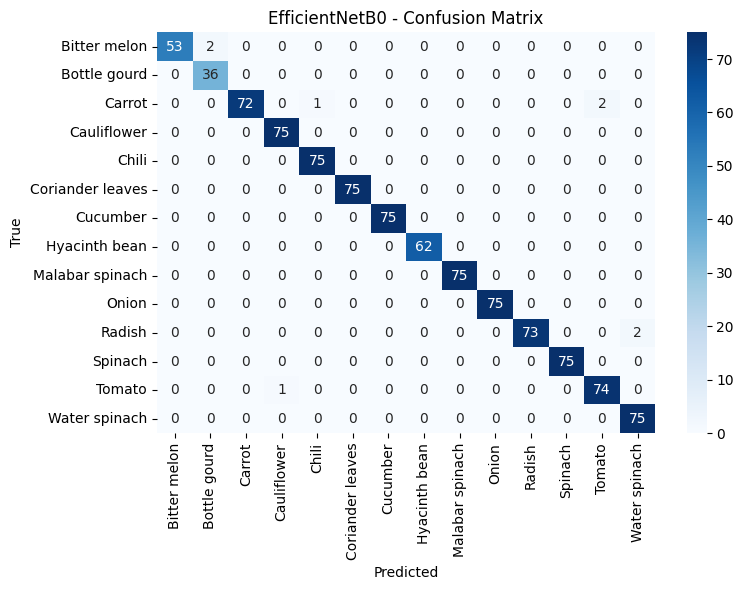

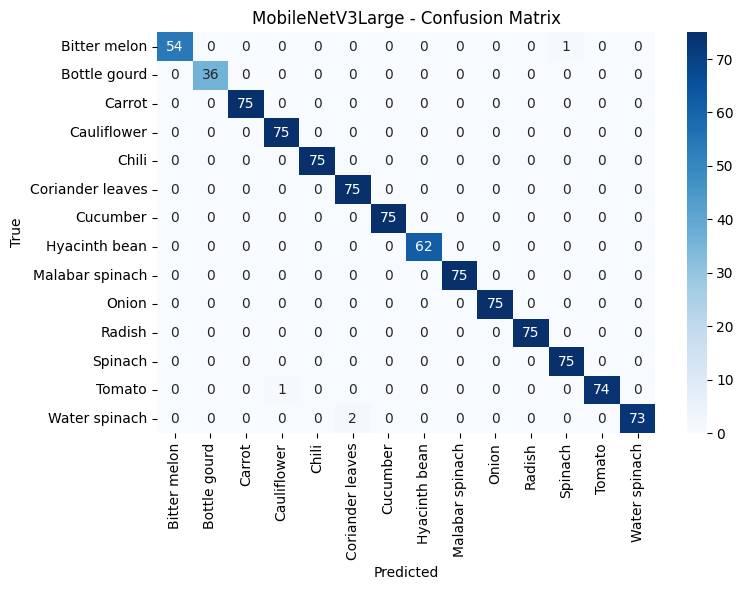

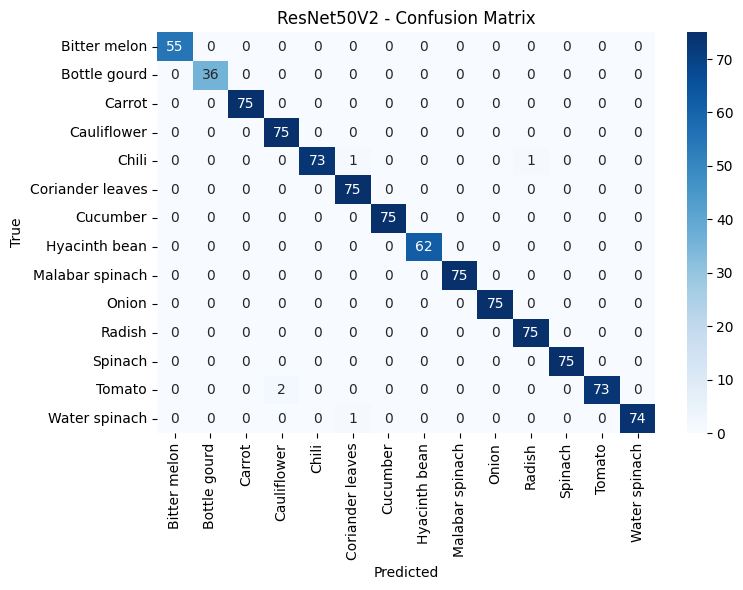

In [34]:

def plot_cm(cm, title, class_names):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(res_e['cm'], 'EfficientNetB0 - Confusion Matrix', class_names)
plot_cm(res_m['cm'], 'MobileNetV3Large - Confusion Matrix', class_names)
plot_cm(res_r['cm'], 'ResNet50V2 - Confusion Matrix', class_names)

**Compare models**


=== Model Comparison ===
           Model  Accuracy
MobileNetV3Large  0.995910
      ResNet50V2  0.994888
  EfficientNetB0  0.991820


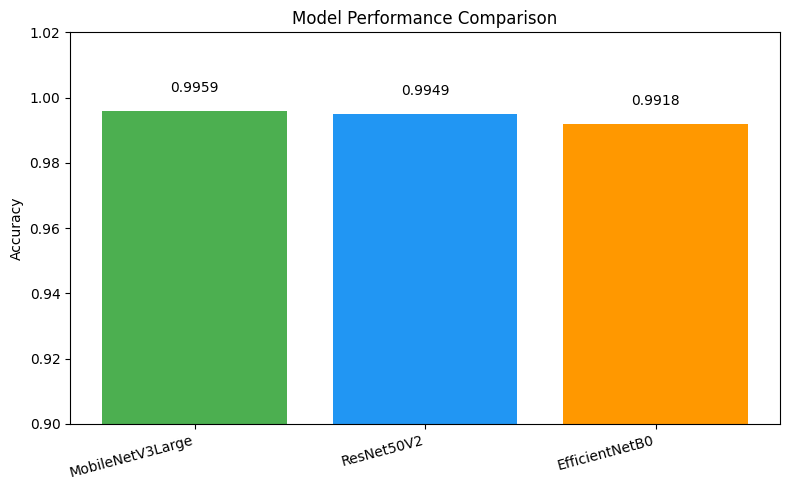

In [37]:
compare = pd.DataFrame([
    {'Model': 'EfficientNetB0', 'Accuracy': res_e['acc']},
    {'Model': 'MobileNetV3Large', 'Accuracy': res_m['acc']},
    {'Model': 'ResNet50V2', 'Accuracy': res_r['acc']},
])
compare = compare.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\n=== Model Comparison ===")
print(compare.to_string(index=False))
# Visualize comparison
plt.figure(figsize=(8, 5))
plt.bar(compare['Model'], compare['Accuracy'], color=['#4CAF50', '#2196F3', '#FF9800'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim([0.9, 1.02])  # Adjusted range for high accuracy values
plt.xticks(rotation=15, ha='right')
for i, v in enumerate(compare['Accuracy']):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

**Plot training history**

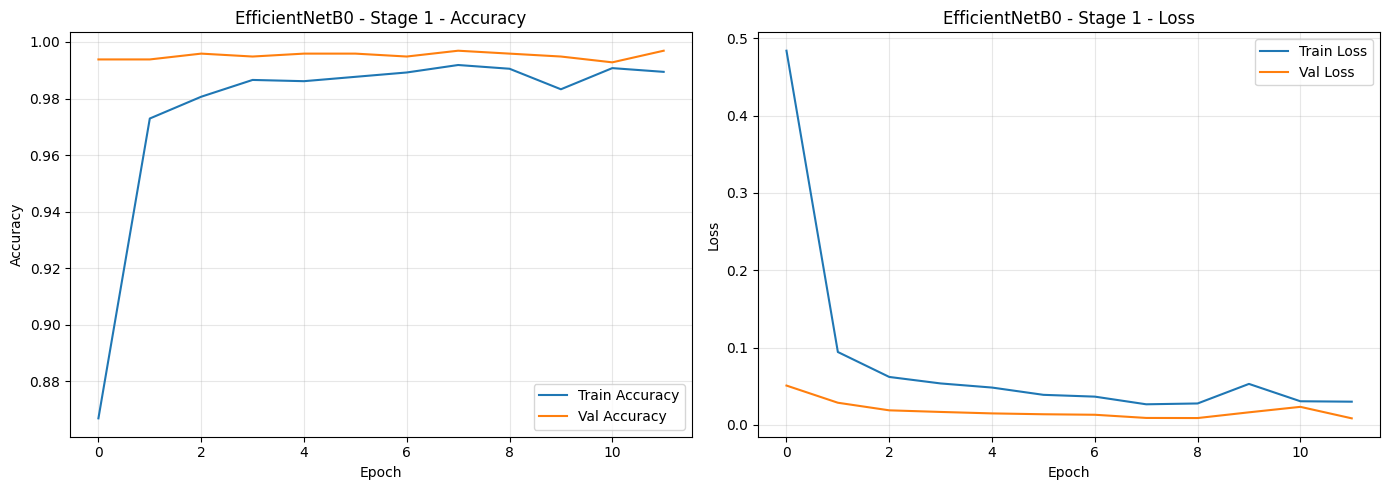

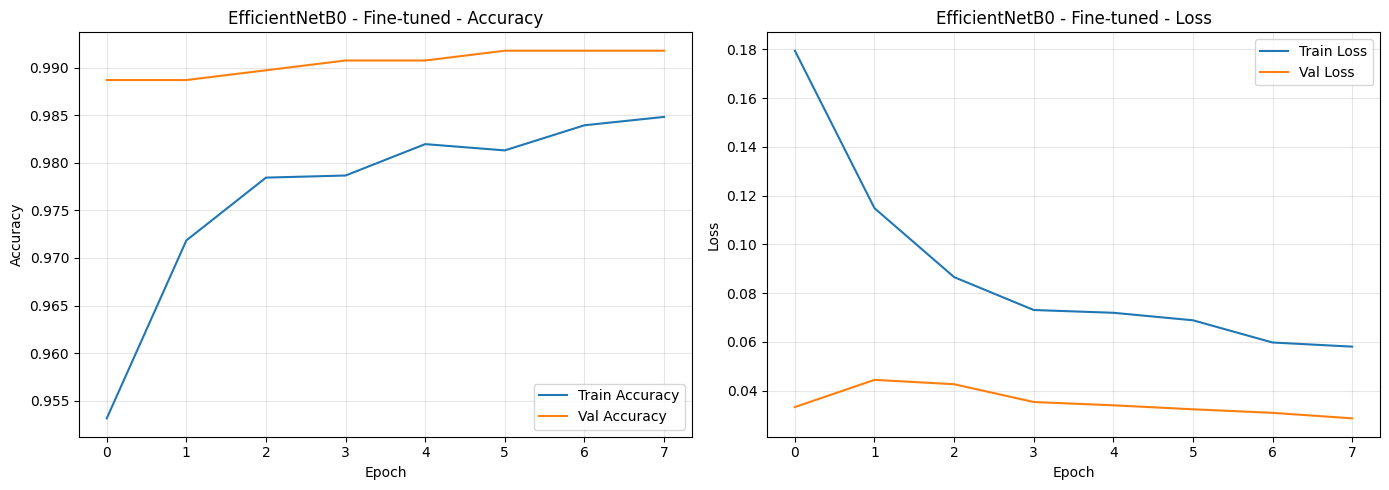

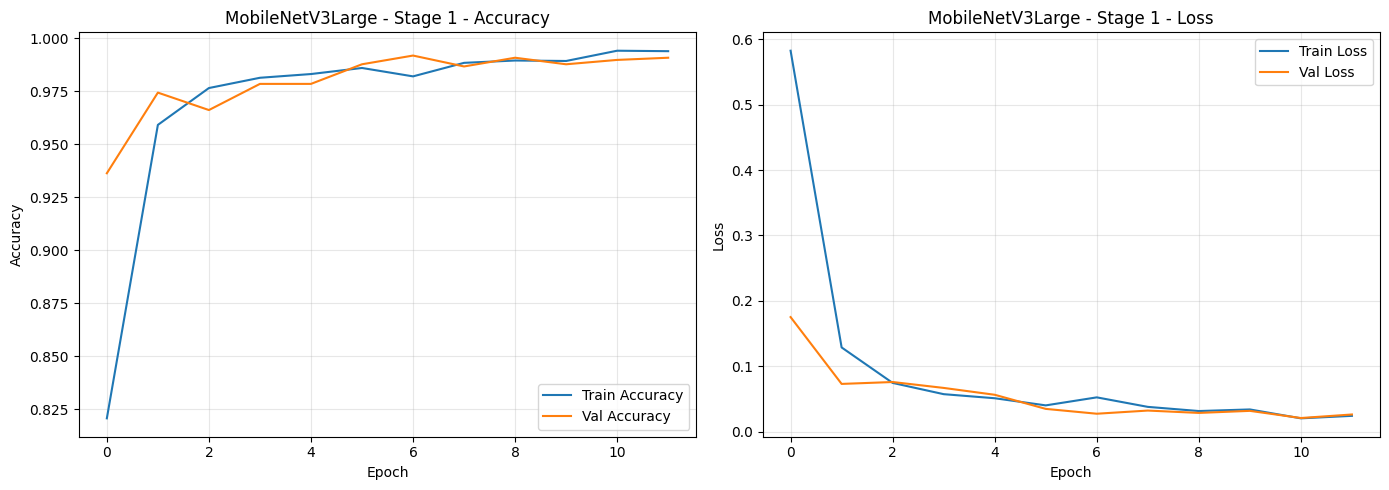

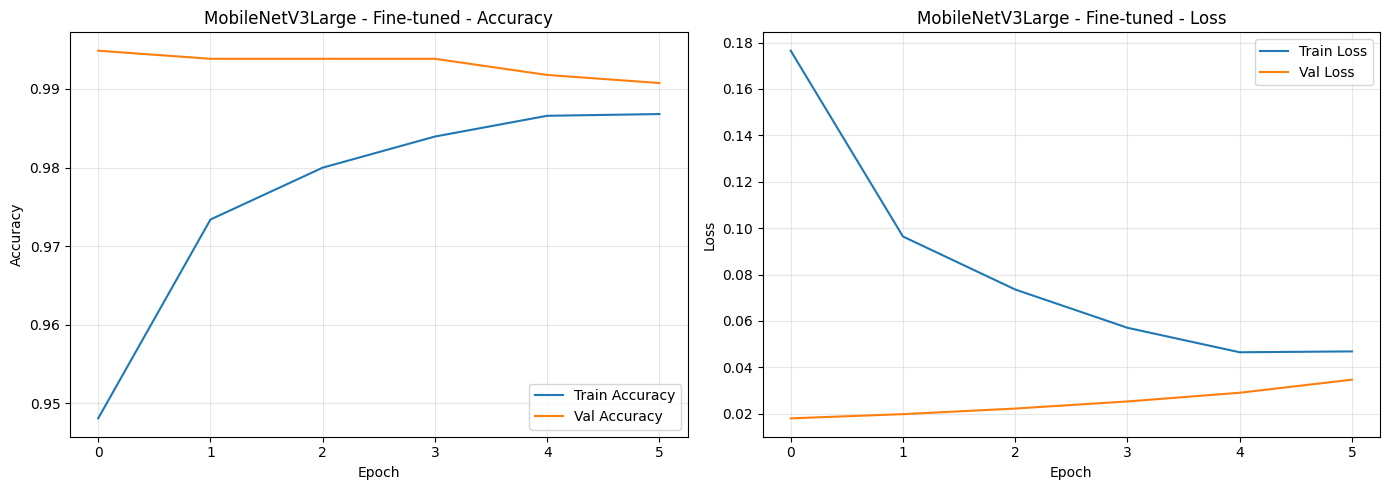

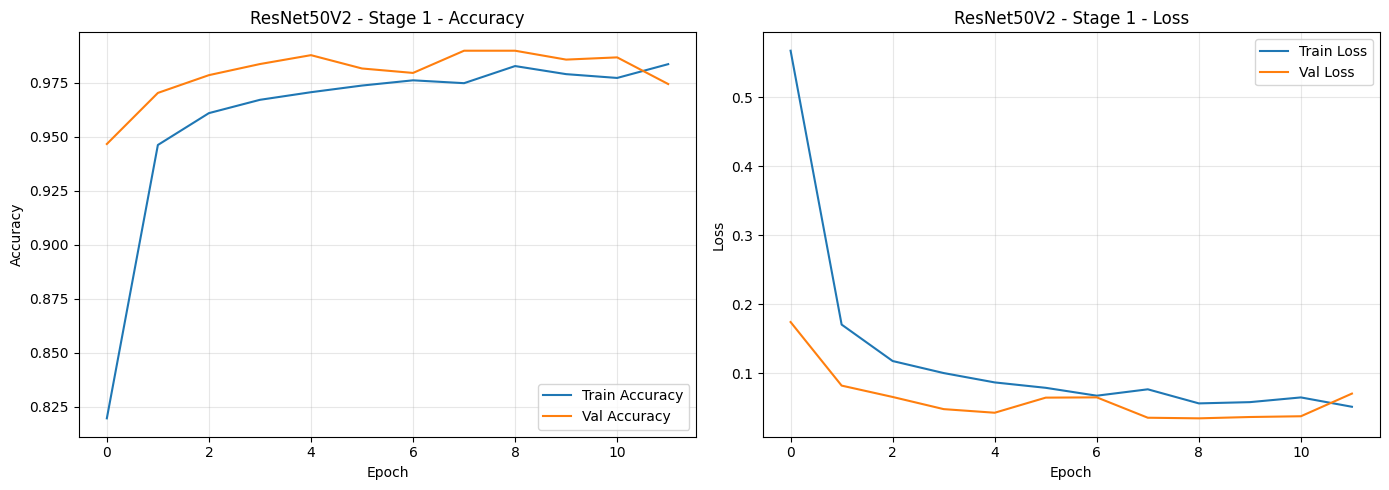

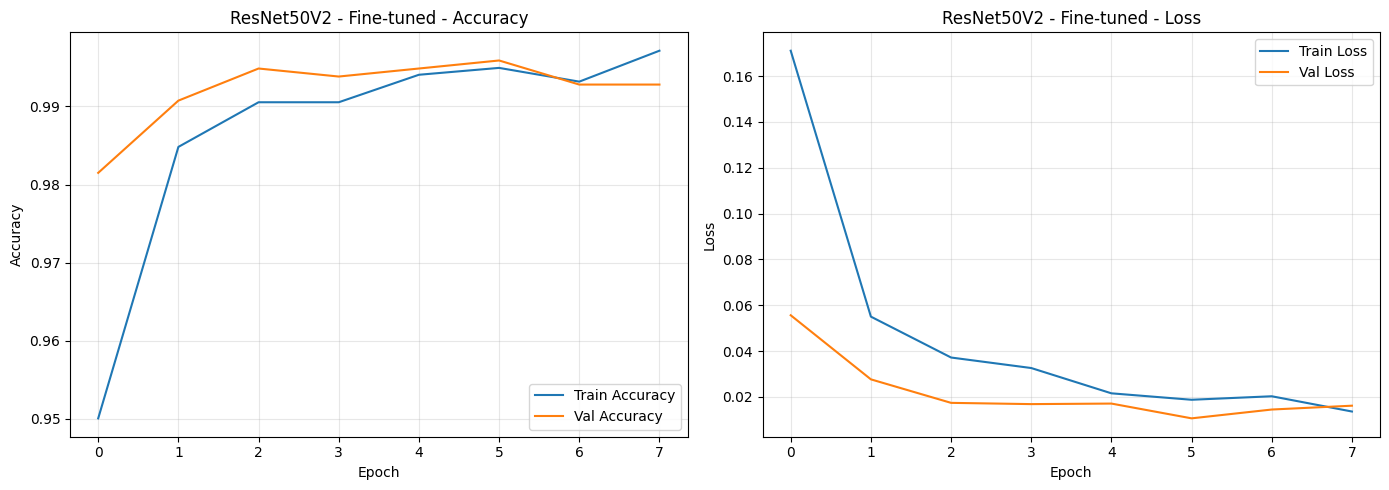

In [38]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_history(history_e, 'EfficientNetB0 - Stage 1')
plot_history(history_e_ft, 'EfficientNetB0 - Fine-tuned')
plot_history(history_m, 'MobileNetV3Large - Stage 1')
plot_history(history_m_ft, 'MobileNetV3Large - Fine-tuned')
plot_history(history_r, 'ResNet50V2 - Stage 1')
plot_history(history_r_ft, 'ResNet50V2 - Fine-tuned')

**Save the best model**

In [39]:
# Determine best model
best_idx = compare['Accuracy'].idxmax()
best_model_name = compare.loc[best_idx, 'Model']
best_acc = compare.loc[best_idx, 'Accuracy']

print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")

# Save best model
if best_model_name == 'EfficientNetB0':
    best_model = model_e
elif best_model_name == 'MobileNetV3Large':
    best_model = model_m
else:
    best_model = model_r

best_model.save('best_seed_classifier.h5')
print("Best model saved as 'best_seed_classifier.h5'")



Best Model: MobileNetV3Large with Accuracy: 0.9959
Best model saved as 'best_seed_classifier.h5'


**Test prediction on sample images**


Sample predictions from MobileNetV3Large:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


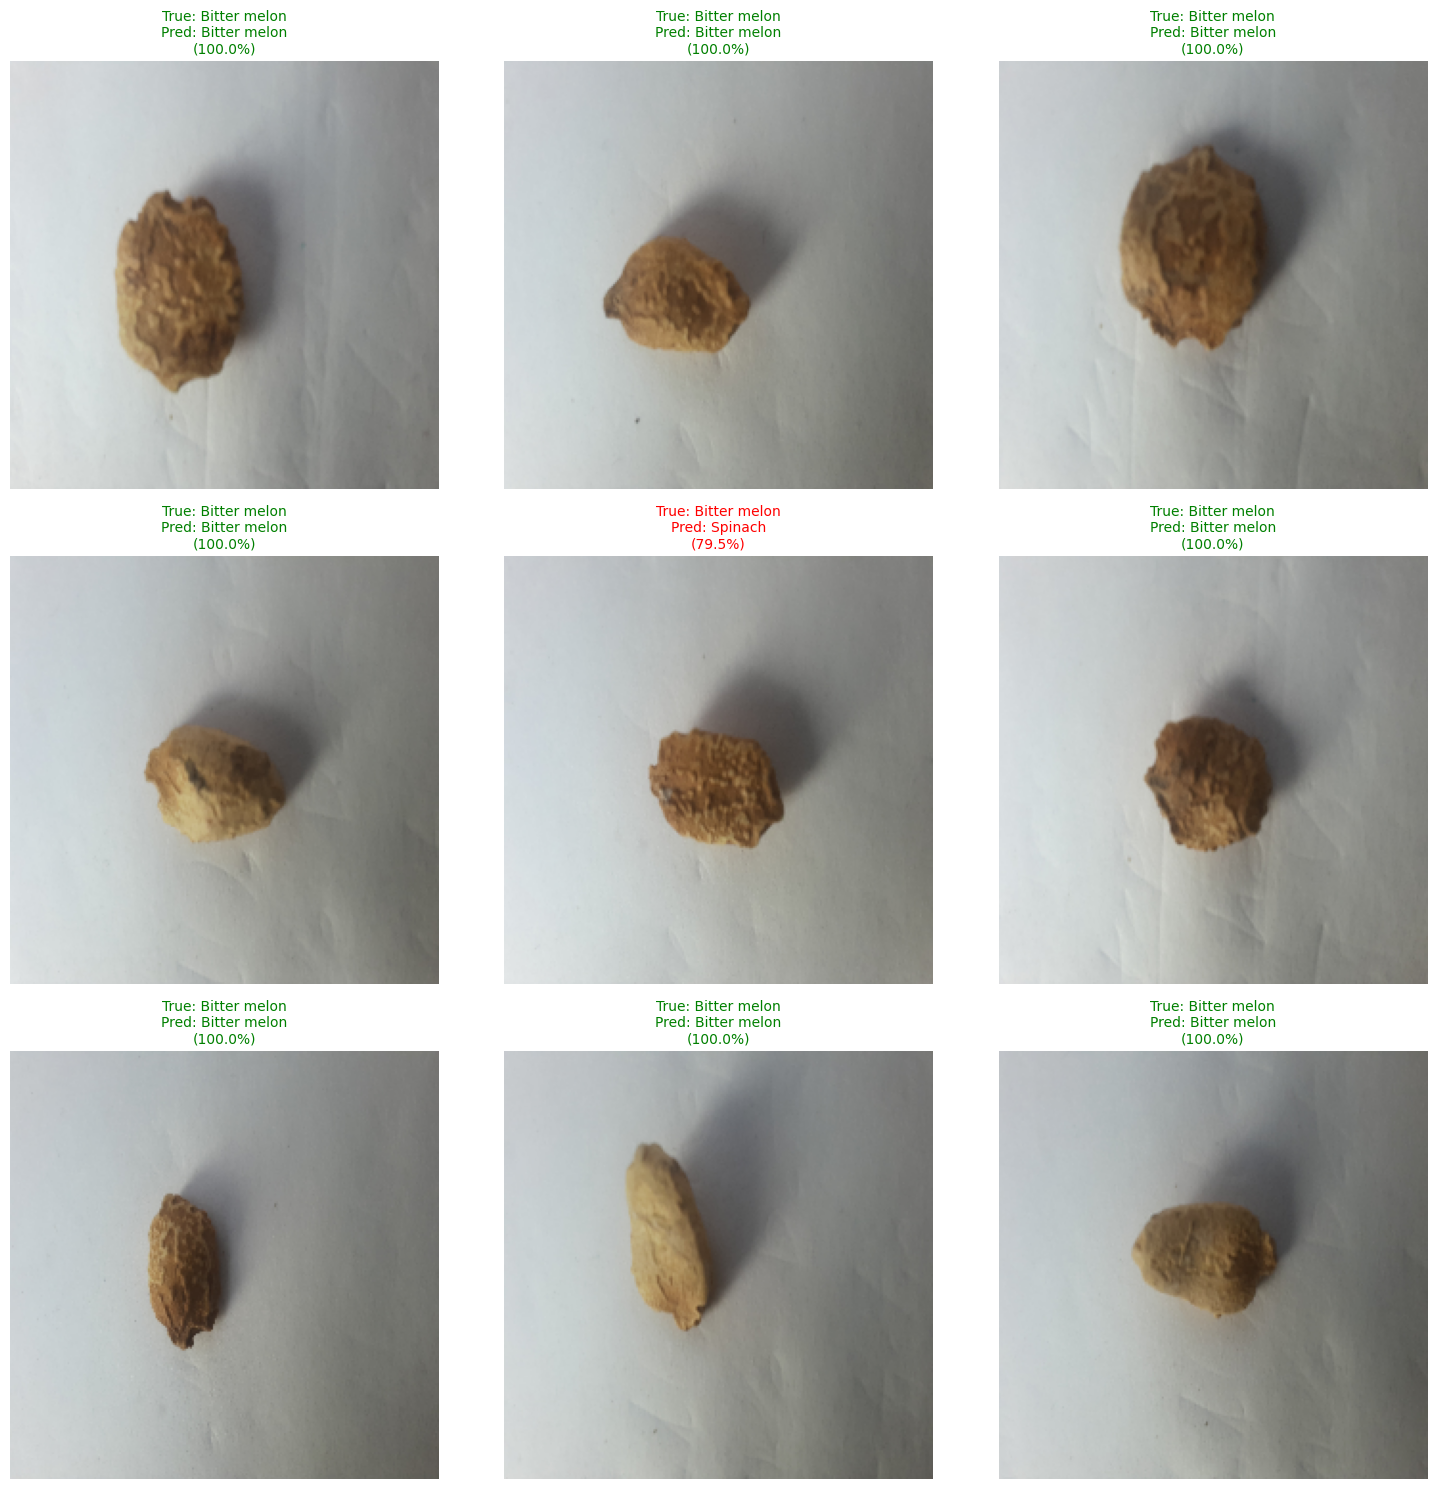

In [41]:
def predict_sample_images(model, test_ds, class_names, num_samples=9):
    """
    Display sample predictions from test set
    """
    # Get one batch
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)

        # Plot
        plt.figure(figsize=(15, 15))
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_classes[i]]
            confidence = predictions[i][pred_classes[i]] * 100

            color = 'green' if pred_classes[i] == labels[i] else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                     color=color, fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Show predictions from best model
print(f"\nSample predictions from {best_model_name}:")
predict_sample_images(best_model, test_ds, class_names)